<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/public_school_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 公立学校スコア
- input
    - public_school_master.csv
        - 小学校の位置とレーティング
        - 中学校の位置とレーティング
        - 区立幼稚園の位置とレーティング
    - private_school_master.csv
        - 私立幼稚園の位置とレーティング
        - 大学の位置
        - 学習塾の位置
- output
    - public_school_score.csv
        - 小学校スコア
        - 中学校スコア
        - 幼稚園スコア
        - 大学スコア
        - 学習塾スコア

In [70]:
!pip install -q japanize-matplotlib

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [73]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [74]:
output_score_file = 'public_school_score.csv'

### 地理マスタ

In [75]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)
geo_master_len = len(df_geo_master)

(3145, 6)


### 学校

In [76]:
df_school_master = pd.read_csv(os.path.join(DIR_NAME, 'public_school_master.csv'))[['学校番号', '施設分類', '市区町村名', '名称', '緯度', '経度', 'rating']]
df_school_master['学校番号'] = df_school_master['学校番号'].astype(str)
print(df_school_master.shape)

(1363, 7)


In [77]:
# レーティングが0.0 の学校は、NaNにする
df_school_master.loc[df_school_master['rating'] == 0, 'rating'] = np.NaN
print(len(df_school_master[df_school_master['rating'].isna()]))

83


In [78]:
df_school_master['施設分類'].value_counts()

小学校    822
中学校    377
幼稚園    164
Name: 施設分類, dtype: int64

In [79]:
df_school_master.head()

,学校番号,施設分類,市区町村名,名称,緯度,経度,rating
0,101150,幼稚園,千代田区,千代田区立麹町幼稚園,35.685691,139.740164,NaN
1,101160,幼稚園,千代田区,千代田区立九段幼稚園,35.690666,139.741195,NaN
2,101170,幼稚園,千代田区,千代田区立番町幼稚園,35.687629,139.733426,5.0
3,101190,幼稚園,千代田区,千代田区立お茶の水幼稚園,35.697445,139.748569,4.0
4,101200,幼稚園,千代田区,千代田区立千代田幼稚園,35.693169,139.768274,NaN


### 学習塾

In [80]:
df_private_master = pd.read_csv(os.path.join(DIR_NAME, 'private_school_master.csv'))[['名称', '緯度', '経度', '施設分類', 'rating']]
print(df_private_master.shape)

(7307, 5)


In [81]:
df_private_master['施設分類'].value_counts()

学習塾        2306
保育園        2093
小学校         694
幼稚園         449
音楽教室        426
中学校         319
幼児教室        286
高等学校        212
大学          177
英語教室        111
プログラミング      91
学童保育         50
専門学校         39
囲碁将棋         31
ダンス          23
Name: 施設分類, dtype: int64

In [82]:
df_university = df_private_master[df_private_master['施設分類'] == '大学'].reset_index(drop=True)
print(df_university.shape)

(177, 5)


In [83]:
df_cram_school = df_private_master[df_private_master['施設分類'] == '学習塾'].reset_index(drop=True)
print(df_cram_school.shape)

(2306, 5)


In [84]:
df_kindergarten = df_private_master[df_private_master['施設分類'] == '幼稚園'].reset_index(drop=True).reset_index()
print(df_kindergarten.shape)

(449, 6)


In [85]:
df_kindergarten['学校番号'] = df_kindergarten['index'].apply(lambda x: f'K{x:05}')
df_kindergarten['区立'] = df_kindergarten['名称'].str.extract('(.+)区立', expand=False)

df_kindergarten = df_kindergarten[df_kindergarten['区立'].isna()].drop(columns=['index', '区立'])
print(df_kindergarten.shape)

(396, 6)


In [86]:
df_kindergarten.head()

,名称,緯度,経度,施設分類,rating,学校番号
0,玉川幼稚園 別館,35.624935,139.614287,幼稚園,NaN,K00000
1,新井幼稚園,35.777931,139.778675,幼稚園,NaN,K00001
2,ちえようちえん,35.791165,139.791125,幼稚園,NaN,K00002
3,ゆたか幼稚園,35.800628,139.866879,幼稚園,4.5,K00003
4,栄光幼稚園,35.789507,139.883900,幼稚園,4.0,K00004


In [87]:
df_school_master = pd.concat([
    df_school_master,
    df_cram_school,
    df_kindergarten,
    df_university
]).reset_index(drop=True)
print(df_school_master.shape)

(4242, 7)


In [88]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

# 最寄り施設までの距離
def get_value_of_nearest_facility_2(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].reset_index(drop=True)
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min_param':
            # 最小の距離の時の他のパラメータを返す
            min_idx = dist.idxmin()
            if np.isnan(min_idx):
                val = np.NaN
            else:
                val = _df_cat.iloc[min_idx][param]
        cat_values.append(val)
    return cat_values

### スコア

In [89]:
school_types = ['小学校', '中学校', '幼稚園']

In [90]:
%%time
for school in school_types:
    # 一番近い施設の距離
    df_geo_master[f'{school}(最近傍距離)'] = get_value_of_nearest_facility(df_geo_master, df_school_master, school, 'min')
    # 最寄りの学校
    df_geo_master[f'{school}(学校番号)'] = get_value_of_nearest_facility_2(df_geo_master, df_school_master, school, 'min_param', '学校番号')

radius = 1    # 1km以内の数
df_geo_master['学習塾(数)'] = get_value_of_nearest_facility(df_geo_master, df_school_master, '学習塾', 'count', radius)
df_geo_master['大学(数)'] = get_value_of_nearest_facility(df_geo_master, df_school_master, '大学', 'count', radius)

print(df_geo_master.shape)

小学校 not found 1050
小学校 not found 1301
小学校 not found 1354
小学校 not found 1357
小学校 not found 2830
中学校 not found 1050
中学校 not found 1354
中学校 not found 1357
中学校 not found 2830
幼稚園 not found 1050
幼稚園 not found 1301
幼稚園 not found 1354
幼稚園 not found 1357
幼稚園 not found 2830
学習塾 not found 1050
学習塾 not found 1354
学習塾 not found 1357
学習塾 not found 2830
大学 not found 1050
大学 not found 1216
大学 not found 1219
大学 not found 1221
大学 not found 1224
大学 not found 1225
大学 not found 1354
大学 not found 1357
大学 not found 2549
大学 not found 2555
大学 not found 2830
大学 not found 3005
大学 not found 3011
大学 not found 3012
大学 not found 3018
大学 not found 3067
大学 not found 3069
大学 not found 3072
大学 not found 3073
大学 not found 3074
大学 not found 3077
大学 not found 3078
大学 not found 3079
大学 not found 3080
大学 not found 3081
大学 not found 3088
(3145, 14)
CPU times: user 3min 5s, sys: 1.28 s, total: 3min 6s
Wall time: 3min 17s


In [91]:
for school in school_types:
    df_geo_master[f'{school}(最近傍距離)'] = df_geo_master[f'{school}(最近傍距離)'].fillna(df_geo_master[f'{school}(最近傍距離)'].max())
    df_geo_master[f'{school}(学校番号)'] = df_geo_master[f'{school}(学校番号)'].fillna('None')

df_geo_master['学習塾(数)'] = df_geo_master['学習塾(数)'].fillna(0).astype(int)
df_geo_master['大学(数)'] = df_geo_master['大学(数)'].fillna(0).astype(int)

In [92]:
for school in school_types:
    df_geo_master = pd.merge(
        df_geo_master, 
        df_school_master[df_school_master['施設分類'] == school][['学校番号', '名称', 'rating']].rename(columns={
            '学校番号': f'{school}(学校番号)', 
            '名称':f'最寄りの{school}', 
            'rating':f'{school}のレーティング'
        }), 
        on=f'{school}(学校番号)', how='left'
    ).drop(columns=[f'{school}(学校番号)'])
    print(school, df_geo_master.shape)

小学校 (3145, 15)
中学校 (3145, 16)
幼稚園 (3145, 17)


In [93]:
df_geo_master.head()

,town_id,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),幼稚園(最近傍距離),学習塾(数),大学(数),最寄りの小学校,小学校のレーティング,最寄りの中学校,中学校のレーティング,最寄りの幼稚園,幼稚園のレーティング
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0.353926,1.689894,0.311683,10,1,中央区立城東小学校,4.1,千代田区立神田一橋中学校,3.5,中央区立昭和幼稚園,NaN
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0.567168,1.628253,0.549758,8,1,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立昭和幼稚園,NaN
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.550874,1.287908,0.550874,9,0,中央区立泰明小学校,3.4,中央区立銀座中学校,3.5,中央区立泰明幼稚園,3.4
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0.594157,0.935392,0.594010,5,2,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0.295715,1.342216,0.292816,6,2,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0


In [94]:
# レーティングがNaNの場合は、平均レーティングで埋める
for target in school_types:
    # 同じ町の平均レーティング
    mean_rating = df_geo_master.groupby(['市区町村名', '町名'])[f'{target}のレーティング'].transform('mean').round(2)
    df_geo_master[f'{target}のレーティング'] = df_geo_master[f'{target}のレーティング'].fillna(mean_rating)
    # それでもNaNの場合は、同じ区の平均レーティング
    mean_rating = df_geo_master.groupby(['市区町村名'])[f'{target}のレーティング'].transform('mean').round(2)
    df_geo_master[f'{target}のレーティング'] = df_geo_master[f'{target}のレーティング'].fillna(mean_rating)

In [95]:
assert len(df_geo_master) == geo_master_len

In [96]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 17)


,town_id,市区町村名,町名,町丁目,緯度,経度,小学校(最近傍距離),中学校(最近傍距離),幼稚園(最近傍距離),学習塾(数),大学(数),最寄りの小学校,小学校のレーティング,最寄りの中学校,中学校のレーティング,最寄りの幼稚園,幼稚園のレーティング
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,0.353926,1.689894,0.311683,10,1,中央区立城東小学校,4.1,千代田区立神田一橋中学校,3.5,中央区立昭和幼稚園,3.4
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,0.567168,1.628253,0.549758,8,1,中央区立城東小学校,4.1,中央区立銀座中学校,3.5,中央区立昭和幼稚園,3.4
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.550874,1.287908,0.550874,9,0,中央区立泰明小学校,3.4,中央区立銀座中学校,3.5,中央区立泰明幼稚園,3.4
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0.594157,0.935392,0.594010,5,2,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0.295715,1.342216,0.292816,6,2,中央区立常盤小学校,4.2,千代田区立神田一橋中学校,3.5,中央区立常盤幼稚園,3.0


### 区ごとの中学受験進学率

In [97]:
shingaku_rate = {
    '文京区': 0.4944,
    '港区': 0.4469,
    '中央区': 0.4245,
    '目黒区': 0.404,
    '千代田区': 0.4012,
    '世田谷区': 0.3577,
    '新宿区': 0.3552,
    '渋谷区': 0.3498,
    '豊島区': 0.3369,
    '品川区': 0.3311,
    '台東区': 0.3194,
    '杉並区': 0.3138,
    '江東区': 0.2916,
    '中野区': 0.2734,
    '北区': 0.2374,
    '大田区': 0.2299,
    '荒川区': 0.1999,
    '練馬区': 0.1768,
    '墨田区': 0.1697,
    '板橋区': 0.1633,
    '葛飾区': 0.141,
    '足立区': 0.1289,
    '江戸川区': 0.1027,
}
df_geo_master['中学受験進学率'] = df_geo_master['市区町村名'].map(shingaku_rate)

### 名門小学校

In [98]:
df_elementary_school = pd.read_csv(os.path.join(DIR_NAME, 'famous_elementary_school.csv'))\
    .rename(columns={'小学校名': '名門小学校名'})\
    .drop_duplicates(subset=['市区町村名', '町丁目'])
print(df_elementary_school.shape)

(151, 3)


In [99]:
df_geo_master = pd.merge(
    df_geo_master,
    df_elementary_school,
    on=['市区町村名', '町丁目'], how='left'
)
df_geo_master['名門小学校'] = 0
df_geo_master.loc[df_geo_master['名門小学校名'].notna(), '名門小学校'] = 1
print(df_geo_master.shape)

(3145, 20)


In [100]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

## 小学校スコア

In [101]:
all_feature_list = []
all_score_list = []

In [102]:
score_name = '小学校スコア'
feature_list = {
    '小学校(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '小学校のレーティング': {'sort': 1, 'weight': 1},
    '中学受験進学率': {'sort': 1, 'weight': 0.5},
    '名門小学校': {'sort': 1, 'weight': 0.3},
}
all_feature_list += ['小学校(最近傍距離)', '名門小学校']
all_score_list.append(score_name)

小学校(最近傍距離)


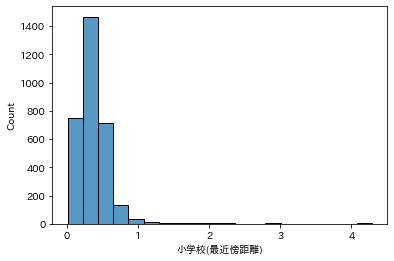

小学校のレーティング


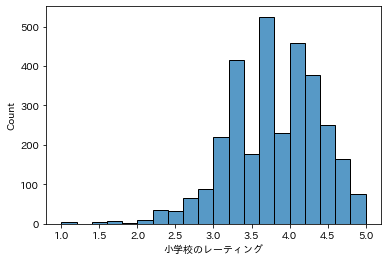

中学受験進学率


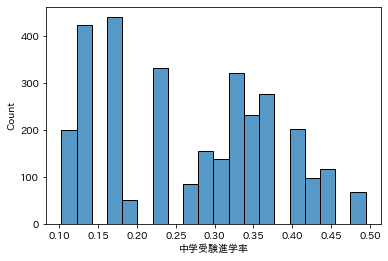

名門小学校


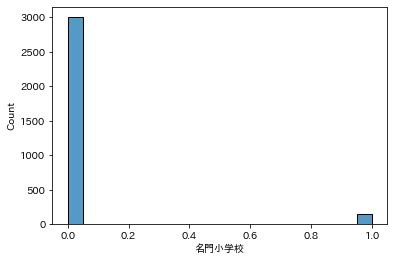

In [103]:
for feature_name in feature_list.keys():
    print(feature_name)
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [104]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

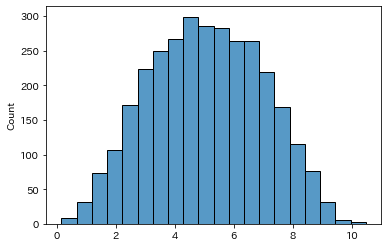

In [105]:
sns.histplot(_tmp_score, bins=20)
plt.show()

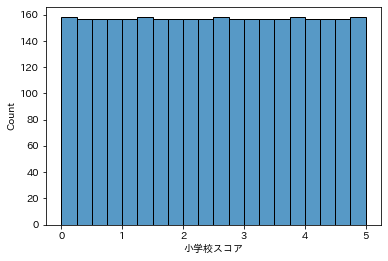

In [106]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [107]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.500000
std         1.444064
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 小学校スコア, dtype: float64

## 中学校スコア

In [108]:
score_name = '中学校スコア'
feature_list = {
    '中学校(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '中学校のレーティング': {'sort': 1, 'weight': 1},
    '名門小学校': {'sort': 1, 'weight': 0.3},
    '中学受験進学率': {'sort': 1, 'weight': 0.3},
}
all_feature_list += ['中学校(最近傍距離)']
all_score_list.append(score_name)

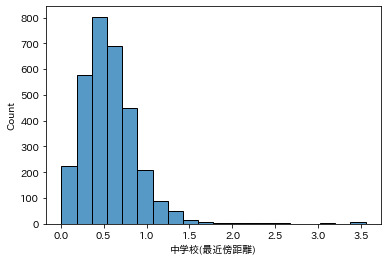

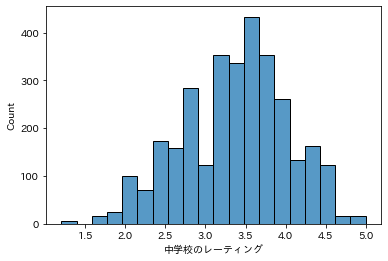

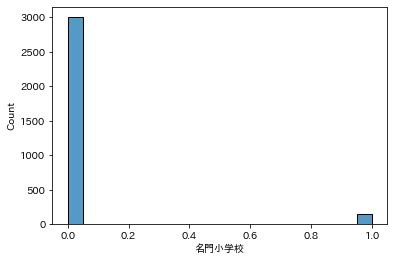

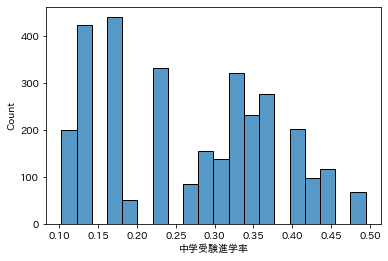

In [109]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [110]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_temp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_temp_score)

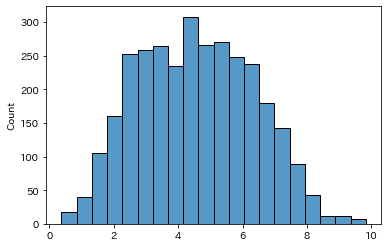

In [111]:
sns.histplot(_temp_score, bins=20)
plt.show()

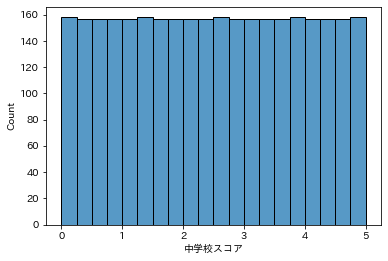

In [112]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [113]:
df_geo_master[score_name].describe()

count    3145.000000
mean        2.500000
std         1.444064
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 中学校スコア, dtype: float64

## 幼稚園スコア

In [114]:
score_name = '幼稚園スコア'
feature_list = {
    '幼稚園(最近傍距離)': {'sort': -1, 'weight': 0.5}, 
    '幼稚園のレーティング': {'sort': 1, 'weight': 1},
    '名門小学校': {'sort': 1, 'weight': 0.5},
    '中学受験進学率': {'sort': 1, 'weight': 0.5},
}
all_feature_list += ['幼稚園(最近傍距離)']
all_score_list.append(score_name)

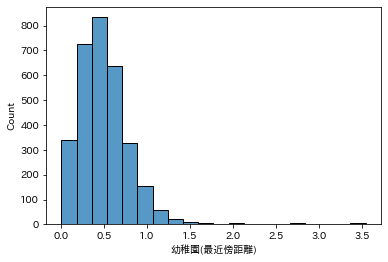

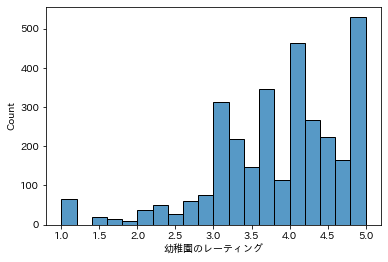

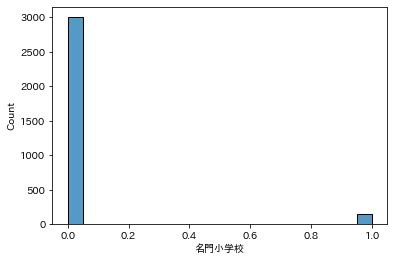

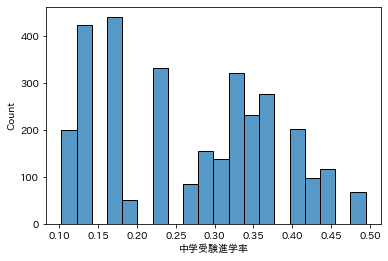

In [115]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [116]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

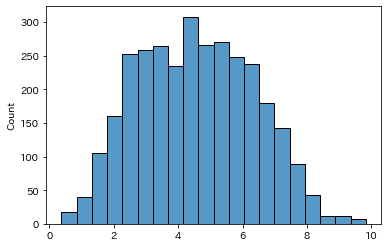

In [117]:
sns.histplot(_temp_score, bins=20)
plt.show()

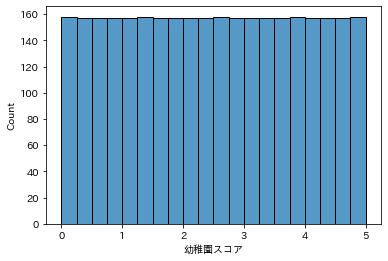

In [118]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

### 学習塾スコア

In [119]:
score_name = '学習塾スコア'
all_score_list.append(score_name)

feature_name = '学習塾(数)'
all_feature_list += [feature_name]

df_geo_master[score_name] = rank_score(df_geo_master[feature_name])

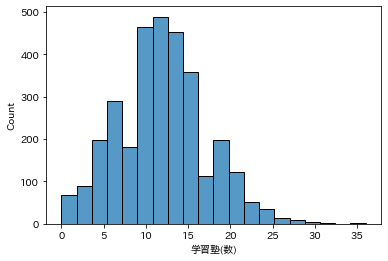

In [120]:
sns.histplot(df_geo_master[feature_name], bins=20)
plt.show()

In [121]:
score_name = '大学スコア'
all_score_list.append(score_name)

feature_name = '大学(数)'
all_feature_list += [feature_name]

df_geo_master[score_name] = rank_score(df_geo_master[feature_name])

## 保存

In [123]:
all_feature_list

['小学校(最近傍距離)', '名門小学校', '中学校(最近傍距離)', '幼稚園(最近傍距離)', '学習塾(数)', '大学(数)']

In [124]:
all_score_list

['小学校スコア', '中学校スコア', '幼稚園スコア', '学習塾スコア', '大学スコア']

In [125]:
for school in school_types:
    df_geo_master[f'{school}(最近傍距離)'] = df_geo_master[f'{school}(最近傍距離)'].round(3)

for col in all_score_list:
    df_geo_master[col] = df_geo_master[col].round(2)

### 保存

In [126]:
df_geo_master[
    ['town_id'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

## 区ごとのスコア確認

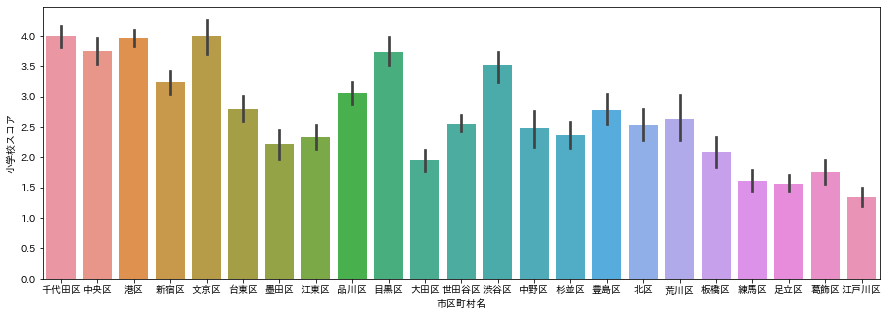

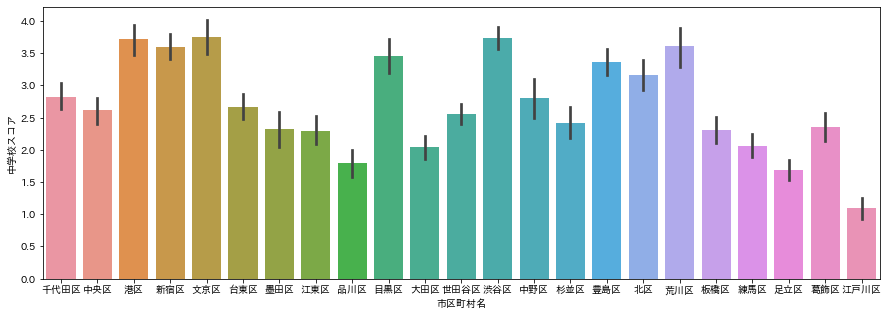

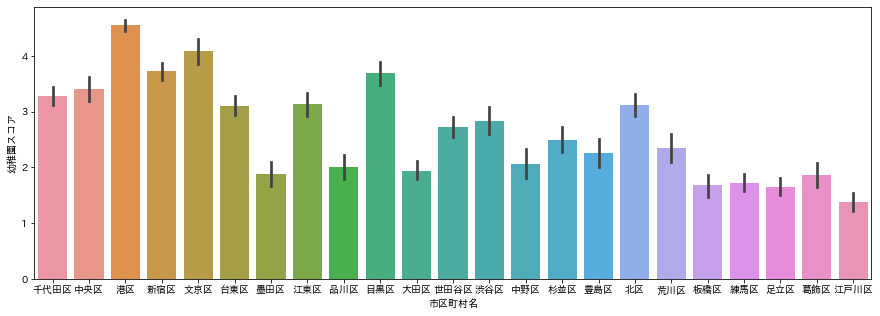

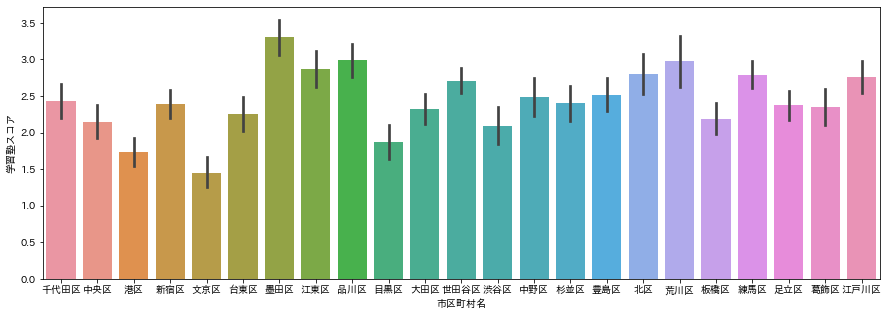

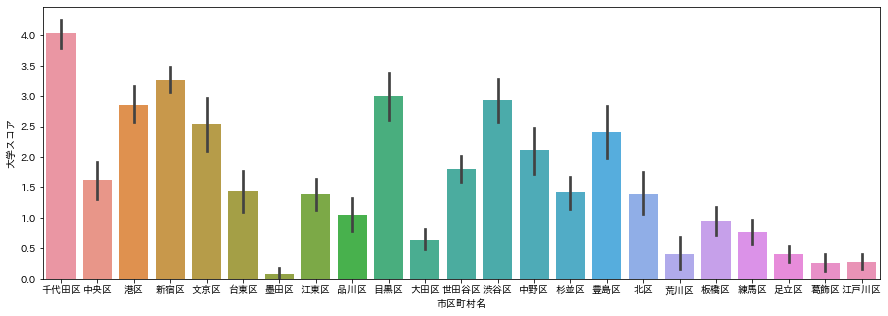

In [127]:
for _score in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=_score, data=df_geo_master)
    plt.show()

In [128]:
def get_score_top(df_data, target):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + [f'最寄りの{target}', f'{target}(最近傍距離)', f'{target}のレーティング', score_name]
    ].reset_index(drop=True)
    return df_level

In [129]:
df_level = get_score_top(df_geo_master, '小学校')
print(df_level.shape)
df_level.head(10)

(904, 7)


,市区町村名,町名,町丁目,最寄りの小学校,小学校(最近傍距離),小学校のレーティング,小学校スコア
0,千代田区,五番町,五番町,千代田区立番町小学校,0.161,4.3,5.00
1,港区,三田,三田１丁目,港区立赤羽小学校,0.100,4.3,5.00
2,世田谷区,玉川田園調布,玉川田園調布２丁目,世田谷区立八幡小学校,0.150,4.7,5.00
3,千代田区,六番町,六番町,千代田区立番町小学校,0.105,4.3,5.00
4,港区,北青山,北青山２丁目,港区立青山小学校,0.238,4.3,4.99
5,文京区,白山,白山１丁目,文京区立誠之小学校,0.132,4.1,4.99
6,文京区,千石,千石２丁目,文京区立林町小学校,0.119,4.6,4.99
7,港区,元麻布,元麻布３丁目,港区立南山小学校,0.080,4.1,4.99
8,目黒区,八雲,八雲２丁目,目黒区立八雲小学校,0.074,4.6,4.99
9,千代田区,神田司町,神田司町２丁目,千代田区立千代田小学校,0.076,4.8,4.99


In [130]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの小学校,小学校(最近傍距離),小学校のレーティング,小学校スコア
894,板橋区,清水町,清水町,板橋区立志村第三小学校,0.324,2.7,0.30
895,江戸川区,松本,松本２丁目,江戸川区立鹿本小学校,0.327,3.0,0.22
896,大田区,平和島,平和島４丁目,大田区立大森第五小学校,0.471,2.8,0.21
897,板橋区,蓮沼町,蓮沼町,板橋区立志村第三小学校,0.402,2.7,0.16
898,葛飾区,水元公園,水元公園,葛飾区立東水元小学校,0.372,2.4,0.13
899,練馬区,上石神井南町,上石神井南町,杉並区立桃井第四小学校,0.710,3.1,0.13
900,江戸川区,二之江町,二之江町,江戸川区立二之江第二小学校,0.396,3.0,0.12
901,練馬区,西大泉町,西大泉町,練馬区立大泉西小学校,0.479,2.6,0.11
902,江戸川区,興宮町,興宮町,江戸川区立下小岩第二小学校,0.380,1.5,0.04
903,江戸川区,一之江町,一之江町,江戸川区立船堀第二小学校,0.481,3.0,0.04


In [131]:
df_level = get_score_top(df_geo_master, '中学校')
print(df_level.shape)
df_level.head(10)

(906, 7)


,市区町村名,町名,町丁目,最寄りの中学校,中学校(最近傍距離),中学校のレーティング,中学校スコア
0,文京区,小石川,小石川４丁目,文京区立茗台中学校,0.224,4.3,5.00
1,千代田区,平河町,平河町２丁目,千代田区立麹町中学校,0.139,4.1,5.00
2,文京区,白山,白山３丁目,文京区立第十中学校,0.379,4.2,4.99
3,港区,西新橋,西新橋３丁目,港区立御成門中学校,0.228,4.0,4.99
4,文京区,千駄木,千駄木５丁目,文京区立文林中学校,0.057,3.8,4.99
5,港区,芝公園,芝公園３丁目,港区立御成門中学校,0.224,4.0,4.99
6,港区,愛宕,愛宕２丁目,港区立御成門中学校,0.204,4.0,4.99
7,千代田区,麹町,麹町４丁目,千代田区立麹町中学校,0.387,4.1,4.98
8,文京区,本駒込,本駒込３丁目,文京区立第九中学校,0.289,3.9,4.98
9,港区,虎ノ門,虎ノ門３丁目,港区立御成門中学校,0.396,4.0,4.98


In [132]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの中学校,中学校(最近傍距離),中学校のレーティング,中学校スコア
896,練馬区,錦,錦２丁目,練馬区立北町中学校,0.943,2.8,0.21
897,足立区,六木,六木１丁目,足立区立第十三中学校,0.902,2.9,0.20
898,新宿区,荒木町,荒木町,新宿区立四谷中学校,0.856,2.0,0.17
899,大田区,雪谷大塚町,雪谷大塚町,大田区立石川台中学校,0.833,2.5,0.15
900,足立区,西伊興町,西伊興町,足立区立伊興中学校,1.023,2.9,0.15
901,新宿区,舟町,舟町,新宿区立四谷中学校,0.928,2.0,0.14
902,江戸川区,大杉,大杉２丁目,江戸川区立松江第四中学校,0.701,2.7,0.14
903,新宿区,大京町,大京町,新宿区立四谷中学校,1.041,2.0,0.11
904,江戸川区,東篠崎町,東篠崎町,江戸川区立篠崎第二中学校,0.547,2.0,0.08
905,葛飾区,水元公園,水元公園,葛飾区立水元中学校,0.726,2.3,0.07


In [133]:
df_level = get_score_top(df_geo_master, '幼稚園')
print(df_level.shape)
df_level.head(10)

(902, 7)


,市区町村名,町名,町丁目,最寄りの幼稚園,幼稚園(最近傍距離),幼稚園のレーティング,幼稚園スコア
0,港区,南麻布,南麻布３丁目,港区立本村幼稚園,0.068,5.0,5.00
1,港区,元麻布,元麻布３丁目,港区立南山幼稚園,0.064,5.0,5.00
2,文京区,千駄木,千駄木５丁目,文京区立千駄木幼稚園,0.145,5.0,5.00
3,港区,三田,三田１丁目,港区立赤羽幼稚園,0.094,5.0,5.00
4,千代田区,麹町,麹町２丁目,千代田区立麹町幼稚園,0.137,5.0,4.99
5,港区,白金,白金３丁目,港区立三光幼稚園,0.133,5.0,4.99
6,千代田区,六番町,六番町,千代田区立番町幼稚園,0.015,5.0,4.99
7,千代田区,五番町,五番町,千代田区立番町幼稚園,0.234,5.0,4.98
8,港区,高輪,高輪２丁目,港区立高輪幼稚園,0.277,5.0,4.98
9,港区,西麻布,西麻布２丁目,港区立青南幼稚園,0.374,5.0,4.97


In [134]:
df_level.tail(10)

,市区町村名,町名,町丁目,最寄りの幼稚園,幼稚園(最近傍距離),幼稚園のレーティング,幼稚園スコア
892,足立区,千住龍田町,千住龍田町,足立幼稚園,0.413,1.0,0.18
893,江戸川区,臨海町,臨海町１丁目,江戸川幼稚園,0.868,3.4,0.18
894,江戸川区,本一色,本一色２丁目,松本幼稚園,0.736,3.1,0.15
895,足立区,皿沼,皿沼２丁目,佐藤幼稚園,0.595,2.8,0.13
896,江戸川区,下篠崎町,下篠崎町,暁幼稚園,0.921,3.3,0.12
897,大田区,羽田旭町,羽田旭町,北糀谷幼稚園,1.766,2.7,0.11
898,江戸川区,興宮町,興宮町,松本幼稚園,0.934,3.1,0.09
899,板橋区,幸町,幸町,要町幼稚園,0.860,1.0,0.03
900,足立区,千住橋戸町,千住橋戸町,足立幼稚園,0.791,1.0,0.01
901,板橋区,大山西町,大山西町,要町幼稚園,1.103,1.0,0.01


In [135]:
df_geo_master.sort_values('学習塾スコア', ascending=False)[['市区町村名', '町名', '町丁目', '学習塾(数)', '学習塾スコア']].head(10)

,市区町村名,町名,町丁目,学習塾(数),学習塾スコア
1506,世田谷区,用賀,用賀２丁目,31,5.00
2986,江戸川区,一之江町,一之江町,36,5.00
2795,葛飾区,立石,立石５丁目,31,5.00
2970,江戸川区,松江,松江６丁目,32,5.00
2092,北区,赤羽南,赤羽南２丁目,29,4.99
2567,足立区,梅田,梅田８丁目,29,4.99
879,江東区,大島,大島５丁目,29,4.99
2702,足立区,西新井栄町,西新井栄町１丁目,29,4.99
880,江東区,大島,大島６丁目,28,4.98
1505,世田谷区,用賀,用賀１丁目,28,4.98


In [136]:
df_geo_master.sort_values('大学スコア', ascending=False)[['市区町村名', '町名', '町丁目', '大学(数)', '大学スコア']].head(10)

,市区町村名,町名,町丁目,大学(数),大学スコア
1051,目黒区,駒場,駒場１丁目,10,5.00
1678,渋谷区,富ケ谷,富ケ谷２丁目,10,5.00
67,千代田区,神田錦町,神田錦町３丁目,10,5.00
62,千代田区,神田駿河台,神田駿河台２丁目,10,5.00
1667,渋谷区,松涛,松涛１丁目,9,4.96
1675,渋谷区,上原,上原２丁目,9,4.96
1666,渋谷区,神泉町,神泉町,9,4.96
1093,目黒区,中央町,中央町１丁目,9,4.96
49,千代田区,一ツ橋,一ツ橋２丁目,9,4.96
61,千代田区,神田駿河台,神田駿河台１丁目,9,4.96
